# Assignment 3: Generalized linear models
## [Scientific Computing with Python](https://scicompy.yoavram.com/)
## Yoav Ram

In [1]:
!~/anaconda3_501/bin/python -m pip install emcee

     |████████████████████████████████| 51kB 420kB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!~/anaconda3_501/bin/python -m pip install corner

  Created wheel for corner: filename=corner-2.0.1-cp36-none-any.whl size=11792 sha256=96a585e10aca01aaa7efa76aa050cfa780ad2acf40a44927d80677b062b87325
  Stored in directory: /home/nbuser/.cache/pip/wheels/70/d8/e5/e0e7974a2a5757483ea5a180c937041cf6872dc9993d78234a
Successfully built corner
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import urllib.request
import os
import zipfile

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import scipy.optimize
import emcee
from corner import corner
import seaborn as sns
sns.set_context('talk')
red, blue, green = sns.color_palette('Set1', 3)

# General instructions

1. When instructed to implement a function, use the given function names and parameters lists; failure to do so may cause test functions to fail during grading.
1. When instructed to generate a plot, make sure that the plot is clear, that axes are propely labeled, and that the notebook is saved with the plot inline, so that the grader can see the plot without running the code. Make sure that you re-generate the plot if you changed the code!
1. Code lines with a triple comment `###` should not be removed or modified, they are used for automatic grading.
1. Note that there are 2 exercises and the last cell in the notebook says **end of assignment**; if you are missing anything please download the origianl file from the course website.
1. This exercise doesn't put much emphasis on efficieny or runtime. *But*, your code should still run within a reasonable time (a few minutes) and you should use idioms learned in class, e.g. array opreations, wherever possible to "lose your loops".
1. Questions regarding the exercises should be posted to the course forum at the designated group (i.e. "assignment3"). You can post questions anonymously. You can also visit the Office Hours, but please do not email the course staff with questions about the exercise.
1. Intructions for submitting the exercise are on the [course website](https://scicompy.yoavram.com/assignments).

# Ex 1: Robust linear regression

Consider the following dataset.

In [4]:
###
df = pd.read_csv('../data/outliers.csv')
df.head()

,x,y
0,0,23.715417
1,3,64.343713
2,9,33.164727
3,14,32.338875
4,15,38.264633


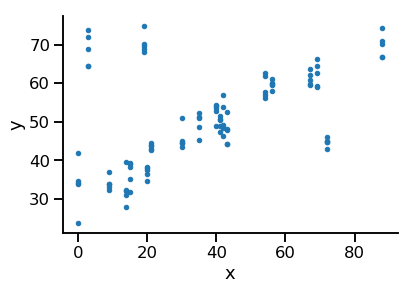

In [5]:
###
x = df['x'].values
y = df['y'].values
plt.plot(x, y, '.')
plt.xlabel('x')
plt.ylabel('y')
sns.despine()

There are several `y` measurements for each `x` value. 
We therefore compute the mean and standard deviation for `y` at each `x` value, and assign the mean back to `y` and the standard deviation to `e`.

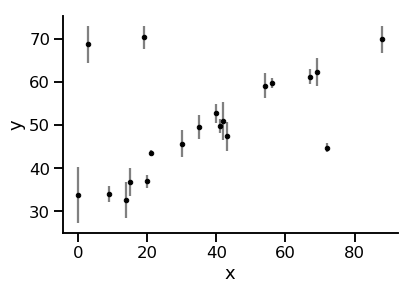

In [6]:
###
e = df.groupby('x')['y'].std(ddof=1).values
y = df.groupby('x')['y'].mean().values
x = np.unique(x)

def plot_data():
    plt.errorbar(x, y, yerr=e, fmt='.k', ecolor='gray')
    plt.xlabel('x')
    plt.ylabel('y')
    sns.despine()
    
plot_data()

We can observe something similar to a linear relationship between `x` and `y`, but with some outliers, especially in the top left corner.

We would like to find a linear model that fits the data. 

The straightforward approach is that of the normal linear model:

$$
\hat{y}_i = a x_i + b \\
y_i \sim N(\hat{y}_i, e_i) \\
$$

Here, we use the estimates `e` for the standard deviation; this can provide a better model fit then estimating one parameter for all `x` values, especially when some of the points are outliers.

**Find the parameters $\theta=(a, b)$ that minimize the negative log-likelihood**, or the loss function, by implementing the loss function (`loss_norm`) and minimizing it.
You can use a function from `scipy.optimize` or do gradient descent, whatever you'd like.

Remember that maximizing the likelihood = maximizing the log-likelihood = minimizing the negative log-likelihood = miniziming the loss function.

*Note* you should use `e` to standardize the residuals: look at the role of σ in the original probability density function of the normal distribution.

In [7]:
def loss_norm(θ, x, y, e): ### 
    a,b = θ
    yhat = a*x + b
    res = (y-yhat)/e
    return (res**2).sum()
    
θ_guess = 35, 0.75 ###
print(loss_norm(θ_guess, x, y, e)) ###
# prints: 14639722.031479657

14639722.031479657


In [8]:
θ_norm = scipy.optimize.fmin(
        loss_norm, # loss function to minimize
        (θ_guess), # guess
        args=(x, y,e) # arguments to loss function
    )

print("Nomral linear model:\n a={:.2f}, b={:.2f}".format(*θ_norm)) ###

Optimization terminated successfully.
         Current function value: 385.354818
         Iterations: 88
         Function evaluations: 167
Nomral linear model:
 a=0.23, b=39.47


We plot the result:

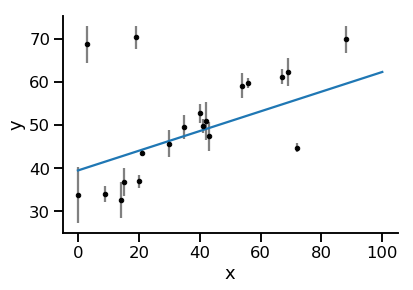

In [9]:
###
a, b = θ_norm
x_range = np.linspace(0, 100)

plot_data()
plt.plot(x_range, a * x_range + b, '-');

It's clear on examination that the outliers are exerting a disproportionate influence on the model fit.
This is due to the nature of the squared loss function.
If you have a single outlier that is 10 standard deviations away from the model lines its contribution to the loss will out-weigh that of 25 points which are 2 standard deviations away!

## Huber linear model for outlier correction

The variety of possible loss functions is quite literally infinite, but one relatively well-motivated option is the [Huber loss](http://en.wikipedia.org/wiki/Huber_loss_function). The Huber loss defines a critical value at which the loss curve transitions from quadratic to linear.
$$
f_{\delta}(x)=\left\{\begin{array}{ll}
\frac{1}{2} x^{2} & \text { for }|x| \leq \delta \\
\delta\left(|x|-\frac{1}{2} \delta\right), & \text { otherwise }
\end{array}\right.
$$

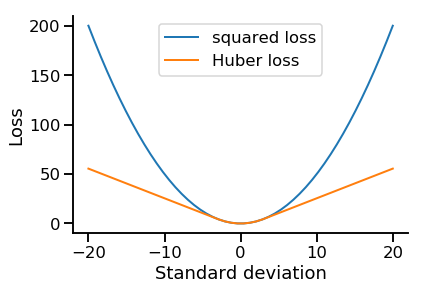

In [10]:
###
def huber(x, δ=3):
    return (
        (abs(x) < δ) * 0.5 * x * x +
        (abs(x) >= δ) * -δ * (0.5 * δ - abs(x)))

t = np.linspace(-20, 20)
plt.plot(t, 0.5 * t * t, label="squared loss", lw=2)
plt.plot(t, huber(t), label="Huber loss", lw=2)
plt.legend()
plt.xlabel('Standard deviation')
plt.ylabel('Loss')
sns.despine()

**Implement the `loss_huber` loss function**, which is similar to the nagative log-likelihood we implemented for the normal model, except that it uses the `huber` function instead of taking the square of the residuals.

In [11]:
def loss_huber(θ, x, y, e, δ=3): ###
    a,b = θ
    yhat = a*x + b
    res = (y-yhat)/e
    return (huber(res, δ)).sum() 

print(loss_huber(θ_guess, x, y, e)) ###
# prints 37893.56096703832

37893.56096703832


**Find the `a` and `b` values that minizime `loss_huber`.**

In [12]:
θ_huber = scipy.optimize.fmin(
        loss_huber, # loss function to minimize
        (θ_guess), # guess
        args=(x, y,e) # arguments to loss function
    )
print("Huber linear model:\n a={:.2f}, b={:.2f}".format(*θ_huber)) ###

Optimization terminated successfully.
         Current function value: 109.172430
         Iterations: 81
         Function evaluations: 158
Huber linear model:
 a=0.39, b=34.73


Now we plot the data with the two model fits. 

The code below plots the data, the normal, and Huber models.

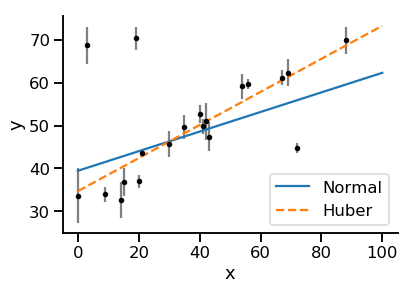

In [13]:
x_range = np.linspace(0, 100) ###

plot_data() ###
a, b = θ_norm
plt.plot(x_range, a * x_range + b, '-', label='Normal')
a, b = θ_huber
plt.plot(x_range, a * x_range + b, '--', label='Huber')
plt.legend();

By eye, this seems to have worked as desired: the fit is much closer to our intuition!

However a Bayesian might point out that the motivation for this new loss function is a bit suspect: as we showed, the squared-loss can be straightforwardly derived from a Gaussian likelihood. The Huber loss seems a bit *ad hoc*: where does it come from? How should we decide what value of $\delta$ to use? Is there any good motivation for using a linear loss on outliers, or should we simply remove them instead? How might this choice affect our resulting model?

## Bayesian linear model: nuisance parameters

The Bayesian approach to accounting for outliers generally involves *modifying the model*.
We propose a more complex model that is a mixture between a signal and background noise:

$$
\hat{y}_i = a x_i + b
\\
y_i \sim \begin{cases}{
    N(\hat{y}_i, e_i) , \quad g_i=1 \\
    N(\hat{y}_i, \sigma), \quad g_i=0 
}\end{cases}
$$

Here, $g_i$ are _nuisance parameters_ that determines if the data point $y_i$ is drawn from the signal distribtion $N(\hat{y}_i, e_i)$, in which the variance is estimated by $e_i^2$, or from the noise distribution $N(\hat{y}_i, \sigma) $, in which the variance is $\sigma^2$ for some relatively large value, say $\sigma=50$.

The likelihood function is therefore:
$$
\mathcal{L}(\theta \mid x, y) = \prod_{i=1}^{n}{\Big[g_i P(y_i \mid a, b, x, e) + (1-g_i) P(y_i \mid a, b, x, \sigma)\Big]}
$$
where $P(y_i \mid a, b, x_i, e_i)$ is the probability density function of $N(ax_i+b, e_i^2)$.

In effect, we will estimate the probability $g_i$ that $y_i$ is _not an outlier_, in the Bayesian sense of probability: belief or confidence. So we are doing a regression problem while performing an auxiliary classification problem.

Our model is much more complex now: it has 22 parameters rather than 2, but the majority of these are $g_i$ which can be considered _nuisance parameters_, and can be marginalized-out in the end (see below).

To actually compute this, we'll start by defining functions describing our prior, our likelihood function, and our posterior.

$\theta$ will be an array of length $2 + N$, where $N$ is the number of points, $a=\theta_0$ is the slope, $b=\theta_1$ is the intercept, and $g_i=\theta_{2+i}$ is the weight of point $i$.

**Implement the log-prior function**. It can be uniform, but consider the bounds you desire for $a$, $b$, and $g_i$.

In [14]:
def log_prior(θ): ###
    # linear model params
    a, b = θ[:2]
    # nuisance params
    g = θ[2:]
    gi_bound = True
    # Check all gi's are between 0 and 1
    for gi in g:
        if gi >= 1 or gi <= 0:
            gi_bound = False
    if (a <= 2 and a >-1) and (b <=55 and b >= 20) and gi_bound:
        return 0
    else:
        return -np.inf

The log-likelihood function is given.

Note: if `g` is 0 or 1, then taking the log of `g` or `1-g` will produce negative infinity. Therefore, we add `ϵ` to `g` and to `1-g` to avoid this numerical issue.

Think: what is `np.logaddexp` and why is it used here?  
**Write a short answer in the cell below**. No more then 3 sentences.

_Write your answer here_.

np.logaddexp(x,y) takes two parameters and sums them and returns of the computed value . We have decided to use this here as it is effective in cases when 
probabilities are very small. 

In [16]:
###
def log_likelihood(θ, x, y, e, σ=50, ϵ=1e-16):
    # linear model params
    a, b = θ[:2]
    # nuisance params
    g = θ[2:]
        
    yhat = a * x + b
    resid = y - yhat    
    resid2 = resid * resid
    logL1 = np.log(g + ϵ) - 0.5 * np.log(2 * np.pi * e * e) - 0.5 * resid2 / (e * e)
    logL2 = np.log(1 - g + ϵ) - 0.5 * np.log(2 * np.pi * σ * σ) - 0.5 * resid2 / (σ * σ)
    return np.logaddexp(logL1, logL2).sum()

In [17]:
###
def log_posterior(θ, x, y, e):
    logpri = log_prior(θ)
    if np.isinf(logpri): return logpri
    return logpri + log_likelihood(θ, x, y, e)

**Finish seting up the model for _emcee_.**

In [18]:
ndim =  22 # number of parameters in the model
nwalkers = 100 # number of MCMC walkers
nsteps = 100000//nwalkers  # number of MCMC steps to take
nburn =  nsteps//2 # burn-in period to let chains stabilize

# set theta near the maximum likelihood, with 
guesses = np.zeros((nwalkers, ndim))
# θ guess drawn around results of normal linear model
guesses[:, :2] = np.random.normal(θ_norm, 1, (nwalkers, 2))
# nuisance params guesses are around 50:50
guesses[:, 2:] = np.random.normal(0.5, 0.1, (nwalkers, ndim - 2))
var_names = ['a', 'b'] + ['g{}'.format(i - 2) for i in range(len(x))] ###

Now we run the sampler.

*Note*: this step might take a few minutes to run.

In [20]:
###
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y, e])
sampler.run_mcmc(guesses, nsteps);

# sampler.chain.shape = (nwalkers, nsteps, ndim)

Lets plot the traces:

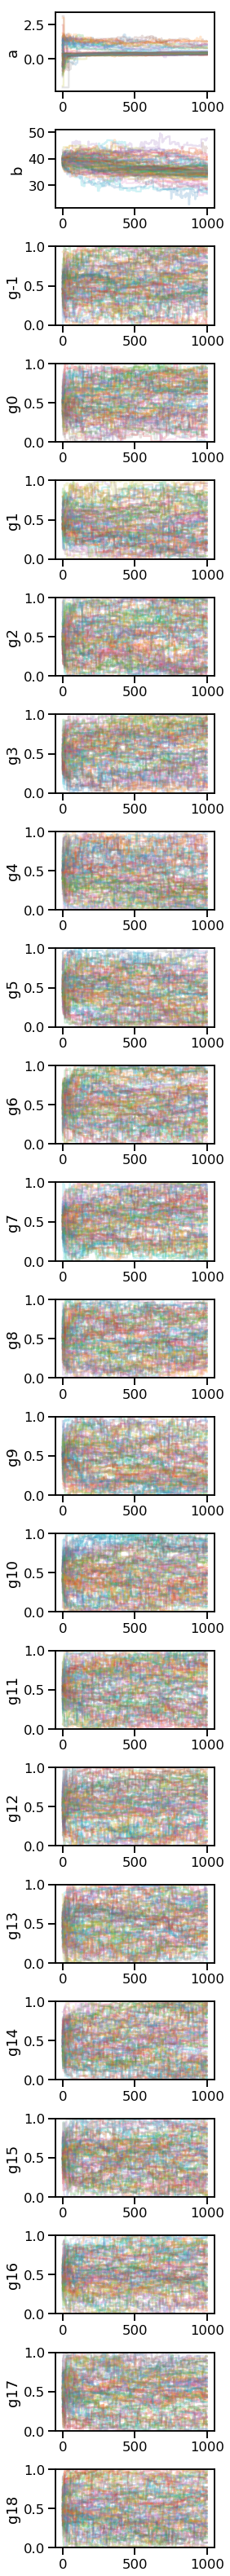

In [21]:
###
fig, axes = plt.subplots(ndim, 1, figsize=(4, ndim*2))

for i, ax in enumerate(axes):
    ax.plot(sampler.chain[:, :, i].T, alpha=0.2)
    ax.set_ylabel(var_names[i])
    if i >= 2: 
        ax.set_ylabel('g{}'.format(i-3))
        ax.set_ylim(0, 1)
fig.tight_layout()

We can exploit a very nice property of the Markov chains.
Because their distribution models the posterior, we can integrate out (i.e. marginalize) over nuisance parameters simply by ignoring them! That's really cool because integrating the posterior is hard. But MCMC is effectively a method for integrating the posterior.

So we can estimate $a$ and $b$ by simply taking their average values over the posterior samples.

In [22]:
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)
θ_bayes = sample[:, :2].mean(axis=0)

print("Huber model:\n a={:.2f}, b={:.2f}".format(*θ_huber))
print("Bayesian mixture model:\n a={:.2f}, b={:.2f}".format(*θ_bayes))

Huber model:
 a=0.39, b=34.73
Bayesian mixture model:
 a=0.49, b=35.91


In [23]:
###
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)
θ_bayes = sample[:, :2].mean(axis=0)

print("Huber model:\n a={:.2f}, b={:.2f}".format(*θ_huber))
print("Bayesian mixture model:\n a={:.2f}, b={:.2f}".format(*θ_bayes))

Huber model:
 a=0.39, b=34.73
Bayesian mixture model:
 a=0.49, b=35.91


Plotting the marginal and joint posterior distributions of $a$ and $b$, we also mark the Huber estimate in blue and the Bayesian estimate in green.

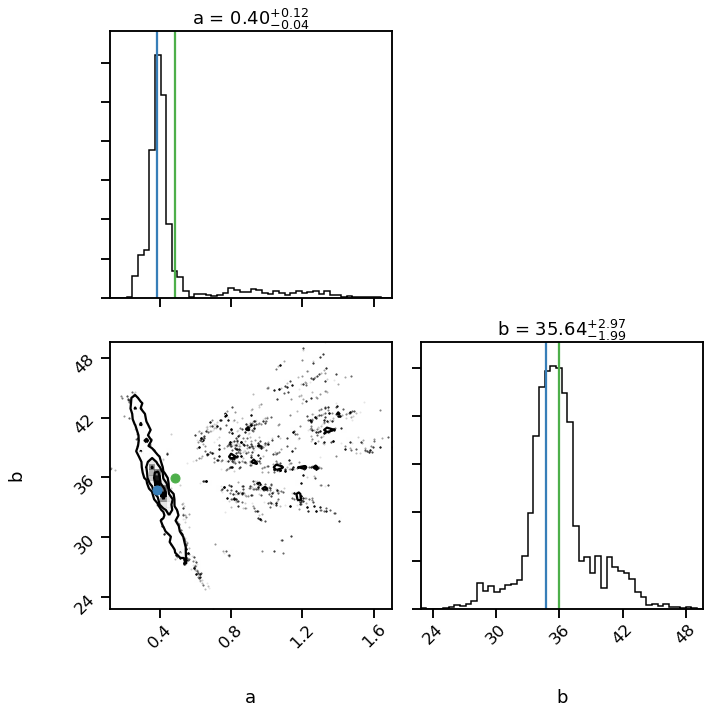

In [24]:
###
cor = corner(
    sample[:,:2], 
    bins=50,
    labels=var_names[:2],
    show_titles=True,
)
for θ_, color in zip([θ_huber, θ_bayes], [blue, green]):
    a_, b_ = θ_
    cor.axes[0].axvline(a_, color=color)
    cor.axes[3].axvline(b_, color=color)
    cor.axes[2].plot(a_, b_, marker='o', color=color)
cor.set_size_inches(10, 10)
cor.tight_layout()

If we focus on the joint distribution around the main density we see that there is some correlation between $a$ and $b$.

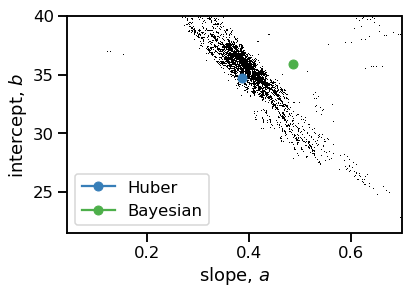

In [25]:
###
plt.plot(sample[:, 0], sample[:, 1], ',k', alpha=1)
for θ_, color, label in zip([θ_huber, θ_bayes], [blue, green], ['Huber', 'Bayesian']):
    a_, b_ = θ_
    plt.plot(a_, b_, marker='o', color=color, label=label)
plt.xlim(None, 0.7)
plt.ylim(None, 40)
plt.ylabel('intercept, $b$')
plt.xlabel('slope, $a$')
plt.legend();

We can predict which data points are outliers using the estimates for $g_i$.

In the cell below, **choose a threshold value** to decide what value of $g$ corresponds to an oulier and what value corresponds to a inlier.

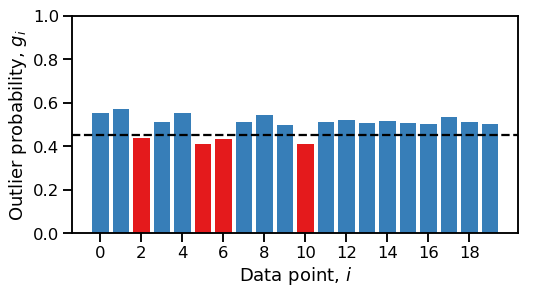

In [26]:
###
thershold = 0.45   # Choose a thershold!

g = np.mean(sample[:, 2:], 0) # estimate g_i by taking mean over posterior
outliers = (g < thershold) # classify outliers

plt.figure(figsize=(8, 4))
plt.bar(np.arange(len(x))[outliers], g[outliers], color=red)
plt.bar(np.arange(len(x))[~outliers], g[~outliers], color=blue)
plt.axhline(thershold, color='k', ls='--')
plt.ylim(0, 1)
plt.xticks(range(0, len(x), 2))
plt.xlabel('Data point, $i$')
plt.ylabel('Outlier probability, $g_i$');

Finally, we can see how the different models compare in terms of model fitting.

Importantly, we can mark the predicted outliers: data points for which $g_i$ is below some threshold.

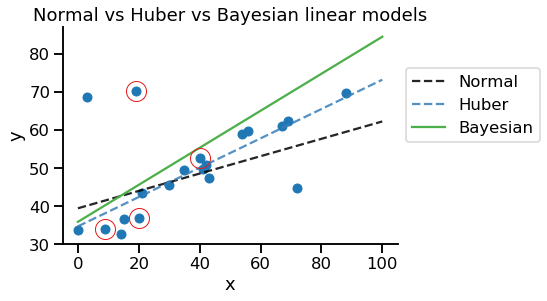

In [27]:
###
plt.plot(x, y, 'o')
plt.plot(x_range, θ_norm[1] + θ_norm[0] * x_range, ls='--', alpha=0.85, label='Normal', color='k')
plt.plot(x_range, θ_huber[1] + θ_huber[0] * x_range, ls='--', alpha=0.85, label='Huber', color=blue)
plt.plot(x_range, θ_bayes[1] + θ_bayes[0] * x_range, label='Bayesian', color=green)
plt.plot(x[outliers], y[outliers], 'ro', ms=20, mfc='none', mec=red)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(bbox_to_anchor=(1, 0.85))
plt.title('Normal vs Huber vs Bayesian linear models')
sns.despine()

Amazingly (?), the Bayesian model produces a much better fit and also identifies as outliers the exact points that we would identify by the "eye test".

# Ex 2: Image classification

We continue with a classification problem, but this time we want to classify an image (an array of pixels) to one of 10 classes (rather than two classes).

We'll use a classical image classification problem, the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset of  handwritten digits. 

First we read the data set from Scikit-learn.

In [35]:
###
from sklearn.datasets import load_digits
X, Y = load_digits(return_X_y=True)

nsamples, nfeatures = X.shape
nclasses = np.unique(Y).size
print("{} samples , {} features (pixels), {} classes".format(nsamples, nfeatures, nclasses))

1797 samples , 64 features (pixels), 10 classes


Images are just arrays of 64 pixels, as you can see.

Each image belong to one of ten classe.

Matplotlib has a special function to plot images: `imshow`.
We wrap it in a function that reshapes the array to a 2D array of 8-by-8 to display the image. We also remove the axes.

In [36]:
# Understanding the data
print("X", X[0])
print("Y", Y)

X [ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
Y [0 1 2 ... 8 9 8]


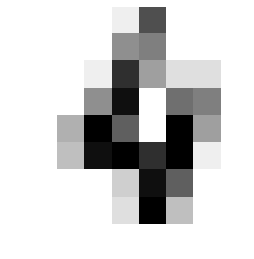

In [37]:
###
def display(x, ax=None):
    if ax is None: fig, ax = plt.subplots()
    ax.imshow(x.reshape((8, 8)), cmap='gray_r')
    ax.set_axis_off()
    
display(X[4])

## Multinomial logistic regression

The target labels are encoded as a nubmer `n` between 0 and 9:

In [38]:
print(np.unique(Y)) ###

[0 1 2 3 4 5 6 7 8 9]


But these are categories, not really numbers. 
We know how to do logistic regression for two categories using a single boolean, and the extension of this idea to $n>2$ categories is called [*multinomial logistic regression*](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) or *softmax regression* (not *multiple*, which means multiple features).
In this framework, we try to predict the log odds ratio $z_k$ that a specific sample or example (a set of feature values $x$) is from category $k$ out of $n$ categories.
So instead of each $x_j$ affecting just a single $z$ via a coefficient $a_j$, we have each $x_j$ affecting each log-odds $z_k$ via a coefficient $a_{k,j}$

$$
z_{k} = \sum_{j=1}^m{a_{k,j} x_j}
$$

If we take the n-by-m matrix $\mathbf{W}$ to have the entries $a_{k,j}$ at row $k$ and column $j$, and $\mathbf{x}$ to be the feautres vector in which $x_{j}$ is the $j$-th feature of the sample, then we can write the same equation using matrix multiplication

$$
\mathbf{z} = \mathbf{W}\mathbf{x}
$$

The probability that the sample $\mathbf{x}$ is from category $k$ is the result of the [*softmax function*](https://en.wikipedia.org/wiki/Softmax_function), an extension of the logistic function for multiple values

$$
\widehat y_k = P(\mathbf{y} = k \mid \mathbf{x}) = \frac{e^{z_k}}{\sum_{j=1}^n{e^{z_j}}}
$$

Note that now $y$, the true label, has to be converted to a vector $\mathbf{y}$ of length $n$ with 1 in one of the positions and 0 everywhere else, so that it would be comparable to $\mathbf{\widehat y}$ which is a probability vector that we get from the log-odds vector $\mathbf{z}$.
The conversion of $y$ from a number between $0$ and $n$ to a vector $\mathbf{y}$ of length $n$ is called [*one-hot encoding*](https://en.wikipedia.org/wiki/One-hot).

**Write a function for this conversion.**

In [39]:
print(len(Y))

1797


In [40]:
def onehot(Y): ###
    # initialise an empty 2D array with 0's
    one_hot = np.zeros((nsamples,10))
    # iterate through 
    for i in range(len(Y)):
        col = Y[i]
        one_hot[i][col] = 1
    return one_hot    

And apply it to our target data:

In [41]:
###
Y = onehot(Y)
print(Y[:5])

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


So Let's start with the multinomial logistic or softmax model.
The model is specified by

$$
\mathbf{z} = \mathbf{W} \mathbf{x} \\
\mathbf{\widehat y} = \mathit{softmax}()
$$

where $\mathbf{z}$ is the linear estimator for the log-odds of the sample being vs. not being in class $k$, and $\widehat y_k$ is the predicted probability of the sample being in class $k$ (just like in the logistic model). 

Let's write a function that creates $\mathbf{W}$ and initilize it to some random values; the specific random distribution we chose is called [*Glorot uniform*](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) and is commonly used in deep learning algorithms:

$$
W_{i,j} \sim U\Big(-\alpha, \alpha\Big), \\
\alpha = \sqrt{\frac{6}{\text{# features} + \text{# classes}}}
$$

In [42]:
def glorot_uniform(nfeatures, nclasses): ###
    # your code here
    𝛼 = np.sqrt(6/(nfeatures+nclasses))
    W = np.random.uniform(low =-𝛼, high =𝛼, size=(nfeatures, nclasses))
    return W

In [43]:
###
W = glorot_uniform(nfeatures, nclasses)
W.shape, W.min(), W.max() # you should get something very similar

((64, 10), -0.28409677618735407, 0.28423388850289255)

To implement the softmax function, we change it a bit to avoid numerical issues of overflow by substracting the largest $z_k$ from the other $z_j$s, so that we deal with exponents of negative numbers, which are easier to compute with high precision.

$$
z_M = max_k{z_k}, \\
\frac{e^{z_k}}{\sum_{j=1}^n{e^{z_j}}} = \frac{e^{z_k - z_M}}{\sum_{j=1}^n{e^{z_j - z_M}}}
$$

We also write the function so that it would work on a 2D array in which each rows are samples and columns are classes (digits 0 to 9), so `max` and `sum` are taken over rows (`axis=1`).

**Implement the `softmax` function.**

Tip: the argument `keepdims` in `np.sum` and `np.max` prevents the aggregation matrices from reducing the number of dimensions which would screw our calculations later on.

In [49]:
def softmax(Z): ### Z is a 2D array with shape (nsamples, nclasses)
    # your code here
    z_m = np.max(Z, axis=1, keepdims=True)
    return np.exp(Z - z_m) / np.sum(np.exp(Z - z_m), axis=1, keepdims=True)
    

In [50]:
assert softmax(X @ W).shape == (nsamples, nclasses) ###

We now implement a prediction function, that accepts an array `W` and array `X` and outputs an array `Yhat`.
Each row in `X` is an image, and for each image we have a row in `Yhat` with 10 elements. These elements are the probabilities of that image belonging to each of the 10 classes, or digits (0, 1, ..., 9).

Tip: The `@` operator performs matrix multiplication in Python.

In [51]:
### 
def predict(W, X):
    Z = X @ W
    Yhat = softmax(Z)
    return Yhat

In [52]:
### 
W = glorot_uniform(nfeatures, nclasses)
Yhat = predict(W, X)
# each row in Yhat is a distribution over the classes
assert Yhat.shape == (nsamples, nclasses)
assert np.allclose(Yhat.sum(axis=1), 1) 

The softmax model uses the same loss function as the logistic model - cross entropy - but with an additional step of averaging not just over samples but also over categories.

In [53]:
###
def cross_entropy(Yhat, Y):
    ylogy = Y * np.log(Yhat)
    return -ylogy.mean()

Accuracy is calculated by comparing the `argmax` of $\mathbf{y}$, the position at which there is a `1` which gives the correct label (so basically reversing the one-hot encoding...), and the argmax of $\mathbf{\widehat y}$, which is the position or category with the highest probability. The `argmax` is taken over columns - classes - using `axis=1`.

Here, the `==` opertor returns an array of booleans, which are sub-types of integers, and `mean` calculates their average, which is the fraction of samples with the correct prediction.

In [54]:
###
def accuracy(Yhat, Y):
    return (Y.argmax(axis=1) == Yhat.argmax(axis=1)).mean()

In [55]:
###
W = glorot_uniform(nfeatures, nclasses)
print("Accuracy: {:.4f}".format(accuracy(predict(W, X), Y)))

Accuracy: 0.1208


This seems about right, as a random model ($\mathbf{W}$) should be expected to be correct at about 10% of the test samples - We didn't fit the model yet!

## Gradient descent

Let's fit the model now.
First we write the function that calculates the gradient.
This is similar to gradient calculation we wrote for logistic regression, but there is some difference.
With logistic regression we effectively had the following code, with $\mathbf{X}$ a matrix with rows for samples and columns for features, $\mathbf{Y}$ a vector with one entry per sample, and $\mathbf{W}$ a vector with one entry per feature.

```python
def gradient(X, Y, W):
    Yhat = expit(X * W)
    δ = Yhat - Y
    dW = X.T @ δ / nsamples
    return dW
```

This worked well because 
`X` was 2D `(nsamples, nfeatures)`, `W` was 1D array `(nfeatures)` and `Y` was 1D `(nsamples)`.
Multiplying `X * W` caused *broadcasting*, such that `W` was automatically reshaped to `(1, nfeatures)` and then to `(nsamples, nfeatures)`. Then the multiplycation worked elementwise $\mathbf{X}_{k,j} \cdot \mathbf{W}_{k,j}$.

This wouldn't work now because `X` is 2D with shape `(nsamples, nfeatures)`, `W` is 2D with shape `(nfeatures, ncats)` and `Y` and `Yhat` are 2D with shape `(nsamples, ncats)`.
So elementwise multiplycation of `X * W` doesn't have a meaning and cannot be broadcasted.

However, if we use matrix multiplication then `X @ W` is 2D `(nsamples, ncats)` as we require from `Yhat` (`expit` doesn't change the shape as it works elementwise).

The matrix multiplication of `X` and `δ` works fine, as broadcasting works just as we want it to, as long as we take the transpose of `X`.

After multiplication we average over the first axis (`nsamples`) so that we get a 2D `(nfeatures, ncats)` array, the same shape as `W`.

This clever design is worth it, because in Python *no loops = efficeint computation*.

**Complete the `gradient` function.**

In [56]:
###
def gradient(W, X, Y): # note that we dont have a bias term here
    if X.ndim == 1: 
        # if we got a single sample, so X is 1D we convert X to 2D with just one row
        # to be consistent with cases in which we get multiple samples (rows)
        X = X[np.newaxis, :]
    nsamples = X.shape[0]
    assert Y.shape[0] == nsamples, "First dimension of X and Y must match"
    yhat = predict(W, X)
    δ = yhat - Y
    dW = X.T @ δ / nsamples
    assert dW.shape == W.shape, (dW.shape, W.shape)
    return dW

## Training with stochastic gradient descent

We encapsulate the gradient descent training process in a `trainer` generator function.
This generator function creates an iterator which, at every iteration, calculates the gradients and updates the coeffieint matrix $\mathbf{W}$. It returns (yields) the number of iterations already performed.

This `trainer` doesn't use all the images at each update but rather just a batch of 50 images.
This is called [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) because we try to estimate the gradient from a sample of the data rather the entire data.
It works well because (i) it's more efficeint in terms of memory to use 50 images at a time; and (ii) it helps to prevent over-fitting and escaping from local minima (of the cross entropy function) because at each stage we use a different set of images.

In [57]:
###
def trainer(W, X, Y, batch_size=20, η=0.001):
    nsamples = X.shape[0]
    batch = 0
    while True:        
        # get next batch
        start = (batch * batch_size) % nsamples
        stop = start + batch_size
        batch_idx = slice(start, stop)
        X_, Y_ = X[batch_idx, :], Y[batch_idx, :]
        
        dW = gradient(W, X_, Y_) # calculate gradients
        
        ΔW = -η * dW # calculate updates
        
        W += ΔW # apply updates in place

        batch += 1
        yield batch # trainer is suspended until next iteration

We have 60,000 images, and work with batches of 50, so it takes 1,200 batches to go over the entire dataset.
This is called an _epoch_.
Let's train for 10 epochs.

In [58]:
### create the naive model - expect low accuracy
W = glorot_uniform(nfeatures, nclasses)
train = trainer(W, X, Y)
print("Accuracy: {:.4f}".format(accuracy(predict(W, X), Y)))

Accuracy: 0.1091


In [59]:
### train for 10 epochs
for batch in train:
    if batch >= 10 * nsamples // 50: break
print("Accuracy ({:d}): {:.4f}".format(batch, accuracy(predict(W, X), Y)))

Accuracy (359): 0.7657


I get about 75% accuracy - you can try and run it longer to see if you get higher accuracy.

**Continue training it until you are satisfied.** Since we are computing the accuracy on the same data used for learning, we can get quite high results -- this is probably due to overfitting, and we should split the data set to a train and test set.

In [60]:
# how many iterations should you perform???
for batch in train:
    if batch >= 1000 * nsamples // 50: break
print("Accuracy ({:d}): {:.4f}".format(batch, accuracy(predict(W, X), Y))) ###

Accuracy (35940): 0.9978


The following code displays some images along with their true and predicted classes.

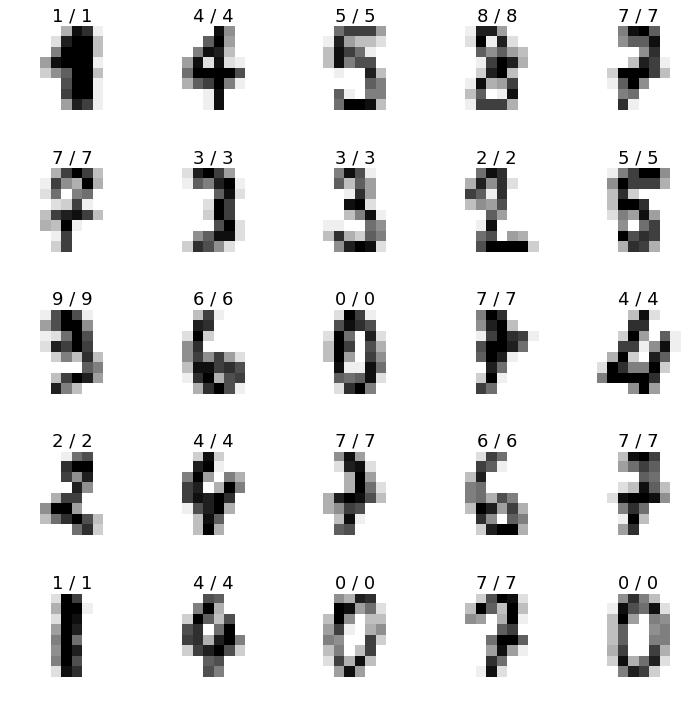

In [61]:
###
idx = np.random.randint(0, len(X), size=25)
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in zip(idx, axes.flat):
    display(X[i], ax=ax)
    y = Y[i].argmax()
    yhat = predict(W, X[i].reshape((1, -1))).argmax()
    ax.set_title('{} / {}'.format(y, yhat))
fig.tight_layout()

**End of assignment**